# üõ† Install Libraries

In [1]:
'''
ak_UWMGI[Train]

'''

# „Ç§„É≥„Çπ„Éà„Éº„É´Ê∏à„Åø„Å™„ÅÆ„Åß„ÄÅ„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà
#!pip install -q segmentation_models_pytorch
#!pip install -qU wandb
#!pip uninstall --yes scikit-learn
#!pip install -q scikit-learn

'\nak_UWMGI[Train]\n\n'

# üìö Import Libraries 

In [196]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import sys
from PIL import Image
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
# tifffile.imread("„Éï„Ç°„Ç§„É´Âêç")„ÅßtiffÁîªÂÉè„ÇíË™≠„ÅøËæº„ÇÅ„Çã
import tifffile as tiff 

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

#import timm ‰ªä„ÅÆ„Å®„Åì„Çç‰∏çË¶Å

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Unet„Çí‰Ωø„ÅÜ„Åü„ÇÅ„ÅÆ„É©„Ç§„Éñ„É©„É™„Çí„Ç§„É≥„Éù„Éº„Éà(smp)
import segmentation_models_pytorch as smp

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ‚öôÔ∏è Configuration 

In [198]:
class CFG:                                                       # „Éë„É©„É°„Éº„Çø‰∏ÄË¶ß
    mean = np.array([0.7720342,0.74582646,0.76392896])
    std =  np.array([0.24745085,0.26182273,0.25782376])
    work_dir      = "/home/user/Desktop/hirao/ftu_segmentation/"
    ckpt_dir      = "/home/user/Desktop/hirao/ftu_segmentation/models_for_use" # ‰ΩøÁî®„Åô„Çã„É¢„Éá„É´„ÅÆÁΩÆ„ÅçÂ†¥ÊâÄ
    
    # Âàá„ÇäÂèñ„Çä„Çµ„Ç§„Ç∫x,y(imagenet„Å®Âêå„Åò256x256„ÅÆ„Éë„ÉÉ„ÉÅ„Å´Âàá„ÇäÂàÜ„Åë„Çã)
    x_csize       = 256
    y_csize       = 256    
    
    seed          = 101
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    model_name    = 'Unet'                         # ‰ΩøÁî®„É¢„Éá„É´
    backbone      = 'efficientnet-b0'              # „Ç®„É≥„Ç≥„Éº„ÉÄ„ÅÆ„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ(Efficientnet)
    train_bs      = 32                             # Â≠¶Áøí„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
    valid_bs      = train_bs*2                     # Ê§úË®º„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫
    img_size      = [3072, 3072]                   # ÁîªÂÉè„Çµ„Ç§„Ç∫(„Åì„ÅÆÂΩ¢„Å´„É™„Çµ„Ç§„Ç∫[„Éë„Éá„Ç£„É≥„Ç∞])
                                                   # „ÅÇ„Åè„Åæ„Åß‰ªÆ„ÅÆÂÄ§„ÄÇË™≠„ÅøËæº„Åø.csv„Åã„ÇâÊúÄÂ§ßÂÄ§„ÇíË®àÁÆó„Åó„Å¶‰∏äÊõ∏„Åç„Åï„Çå„Çã„ÄÇ
    epochs        = 5                             # „Ç®„Éù„ÉÉ„ÇØÊï∞
#    lr            = 2e-3                           # Â≠¶ÁøíÁéá
    lr            = 1e-2                           # Â≠¶ÁøíÁéá
    scheduler     = 'CosineAnnealingLR'            # lr„Åå„Ç≥„Çµ„Ç§„É≥„Ç´„Éº„Éñ„ÇíÊèè„ÅèÂΩ¢„ÅßÊ∏õË°∞„Éª‰∏äÊòá
    min_lr        = 1e-6                           # ÊúÄÂ∞èÂ≠¶ÁøíÁéá
    T_max         = int(30000/train_bs*epochs)+50  # „Ç≥„Çµ„Ç§„É≥„Ç´„Éº„Éñ„ÅÆÂçäÂë®Êúü„ÅÆ„Çπ„ÉÜ„ÉÉ„Éó„Çµ„Ç§„Ç∫[epoch]
                                                   # epoch„ÅåÈÄ≤„ÇÄ„Å®Â§âÂãï„ÅåÁ∑©„ÇÑ„Åã„Å´„Å™„ÇãÔºü
    T_0           = 25                             # 1„Å§„ÇÅ„ÅÆÂë®Êúü„ÅåÁµÇ„Çè„Çãepoch?
    warmup_epochs = 0                              # ÊúÄÂàù„ÅÆÂ≠¶ÁøíÁéá„Çí‰Ωé„ÇÅ„Å´Ë®≠ÂÆö„Åó„ÄÅÊåáÂÆöepoch„Åæ„Åß‰∏äÊòá„Åï„Åõ„Çã
    wd            = 1e-6                           # Èáç„Åø„ÇíÊäëÂà∂„ÅóÈÅéÂ≠¶Áøí„ÇíÈÅø„Åë„Çãweight decay(L2„Éé„É´„É†)
    n_accumulate  = max(1, 32//train_bs)           # „Éê„ÉÉ„ÉÅÊï∞„ÅåÂ∞è„Åï„ÅÑ„Å®„É≠„Çπ„ÇÇÂ∞è„Åï„Åè„Å™„Çã„Çà„ÅÜ„Å´„Åô„Çã
#    n_accumulate  = 1
    n_fold        = 5                              # „Éá„Éº„Çø„ÇíÂàÜÂâ≤„Åô„Çã„Å®„Åç„ÅÆÂàÜÂâ≤Êï∞(5„ÅÆÂ†¥Âêà,Ê§úË®º:Â≠¶Áøí=1:4„Å®„Å™„Çã)
    folds         = [0,1,2,3,4]                            # „Éï„Ç©„Éº„É´„ÉâÊï∞
    num_classes = 1 # „Éû„Çπ„ÇØ„ÅÆ„ÉÅ„É£„É≥„Éç„É´„ÅØ1„Å§
    thr           = 0.40
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # ËÉåÊôØ„Å®Ë¶ãÂÅö„ÅôÁôΩËâ≤„ÅÆÂâ≤Âêà(0.8‰ª•‰∏ä„ÅØËÉåÊôØ)
    w_th          = 0.8   
    # ËÉåÊôØÈô§Â§ñ„Çí‰ΩøÁî®„Åô„Çã„Åã„Å©„ÅÜ„Åã(True or False)
    use_white_area = True

# ‚ùó Reproducibility

In [199]:
def set_seed(seed = 70):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


## Test

In [200]:
'''
„Åì„Åì„Åã„ÇâÂÆüÈöõ„ÅÆÊé®Ë´ñÂá¶ÁêÜÈñãÂßã
'''

# Êé®Ë´ñÁî®„ÅÆ„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„Åø
sub_df = pd.read_csv(CFG.work_dir + 'test.csv') # test.csv„ÇíË™≠„ÅøËæº„Åøsub_df„Å´ÂÖ•„Çå„Çã
# „Éá„Éº„Çø„Åå1Ë°å„ÅÆÂ†¥Âêà(„ÉÜ„Çπ„ÉàÊú¨Áï™„Åß„Å™„ÅÑÂ†¥Âêà)
if len(sub_df)==1:                       # „Éá„Éº„Çø„Åå1Ë°å„Åó„ÅãÂÖ•„Å£„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà,train.csv„ÇíË™≠„ÅøËæº„ÇÄ
#if len(sub_df)==0:                       # 1Ë°å„ÅÆ„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÇíÂá¶ÁêÜ„Åó„Å¶„Åø„Çã„Åü„ÇÅ„Å´„ÄÅË®≠ÂÆö
    print("only 1 sample sample_submission")
    debug = True                         # debug=>True train„Åã„ÇâË™≠„ÅøÂèñ„Çä„ÅÆÂ†¥ÂêàTrue„Å®„Å™„Çã
    sub_df = pd.read_csv(CFG.work_dir + 'train.csv') # train.csv„ÇíË™≠„ÅøËæº„ÇÄ
#    sub_df = sub_df[:30]                    # 30Ë°å„Åæ„Åßsub_df„Å´ÂÖ•„Çå„Çã(Á©∫„ÅÆ„Éá„Éº„Çø„ÅØ„Å™„ÅÑ)
    sub_df = sub_df[:5]                    # [ÊôÇÈñìÁü≠Á∏ÆÁî®] 5Ë°å„Åæ„Åßsub_df„Å´ÂÖ•„Çå„Çã(Á©∫„ÅÆ„Éá„Éº„Çø„ÅØ„Å™„ÅÑ)
#    sub_df = sub_df                    # ÂÖ®„Å¶sub_df„Å´ÂÖ•„Çå„Çã(„É°„É¢„É™Á≠â„ÅÆË≤†ÊãÖ„ÇíÁ¢∫Ë™ç„Åô„Çã„Åü„ÇÅ„Å´ÂÖ®„Å¶Ë™≠„ÅøËæº„ÇÄ)
    sub_df = sub_df.drop(columns=['rle']).drop_duplicates() # Á≠î„Åà„Å®„Å™„Çã'rle'Âàó„Å†„Åë„ÇíÈô§Âéª„Åó„ÄÅÈáçË§á„Åó„ÅüË°å„ÇÇ„ÅÇ„Çå„Å∞Èô§Âéª„Åô„Çã„ÄÇ
# „Éá„Éº„Çø„Åå1Ë°å„Åß„Å™„ÅÑÂ†¥Âêà(„ÉÜ„Çπ„ÉàÊú¨Áï™„ÅÆÂ†¥Âêà)
else:
    print("test launch!")
    debug = False                         # debug=>False sample_submission„Åã„Çâ„ÅÆÂ†¥ÂêàFalse

display(sub_df.head()) # ‰∏ä„Åã„Çâ3Ë°å„ÇíË°®Á§∫„Åô„Çã

only 1 sample sample_submission


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness   age     sex  
0                 4  37.0    Male  
1                 4  76.0    Male  
2                 4  82.0    Male  
3                 4  78.0    Male  
4                 4  21.0  Female

In [201]:
'''
padding„ÅßÊèÉ„Åà„Çã„Åπ„ÅçÁîªÂÉè„ÅÆ„Çµ„Ç§„Ç∫„ÇíÊ±Ç„ÇÅ„ÄÅCFG.img_size„ÇíÊõ¥Êñ∞„Åô„Çã„ÄÇ
'''
# ÁîªÂÉè„ÅÆÊúÄÂ§ßÈ´ò„Åï„ÇíÁ¢∫Ë™ç„Åô„Çã„ÄÇ
max_height = sub_df["img_height"].max()
# ÁîªÂÉè„ÅÆÊúÄÂ§ßÂπÖ„ÇíÁ¢∫Ë™ç„Åô„Çã„ÄÇ
max_width = sub_df["img_width"].max()
# ÁîªÂÉè„ÅÆÊúÄÂ§ßÂπÖ„Å®ÊúÄÂ§ßÈ´ò„Åï„ÅÆÂÜÖ„ÄÅÂ§ß„Åç„ÅÑÊñπ„Çímax_size„Å´ÂÖ•„Çå„Çã„ÄÇ(Âü∫Êú¨ÂπÖ„Å®È´ò„Åï„ÅØÂêå„Åò„Å®Êé®Ê∏¨)
max_size = max(max_height, max_width)
# UnetÊúÄ‰ΩéËß£ÂÉèÂ∫¶Ôºù32„ÅÆ„Åü„ÇÅ„ÄÅÁîªÂÉè„Åå32„ÅÆÂÄçÊï∞„Åß„ÅÇ„ÇãÂøÖË¶Å„Åå„ÅÇ„Çã„ÄÇ(Âæå„Å´256x256„Å´ÂàÜÂâ≤)
# Ëá™ÂãïÁöÑ„Å´ÊúÄÂ§ß„Çµ„Ç§„Ç∫„Çà„ÇäÂ§ß„Åç„Åè„ÄÅ32„ÅÆÂÄçÊï∞„Å´ÊúÄ„ÇÇËøë„ÅÑÂÄ§„Çímax_size„Å®„Åô„Çã„ÄÇ
max_size = max_size + (32 - max_size%32) if max_size%32 != 0 else max_size
CFG.img_size = [max_size, max_size]
print("CFG.img_size:\n",CFG.img_size)

'''
ÁîªÂÉè„Éë„Çπ„ÇíË¶ÅÁ¥†„Å´ÊåÅ„Å§path_df„Çí‰ΩúÊàê„Åô„Çã
'''
if debug: # debug=True„ÅÆÂ†¥Âêà„ÄÅ„Å§„Åæ„Çätrain„Åã„Çâsub_df„Çí‰ΩúË£Ω„Åó„ÅüÂ†¥Âêà
    # paths = Â≠¶Áøí„Éï„Ç©„É´„ÉÄ„ÅÆpng„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
    paths = glob(CFG.work_dir + 'train_images/**/*tiff',recursive=True)
#     paths = sorted(paths)

else: # ÊèêÂá∫„Åó„Åü„Ç≥„Éº„Éâ„ÅåÊú¨Áï™„ÅßÂÆüË°å„Åï„Çå„ÇãÂ†¥Âêà
        
    # paths = test„Éï„Ç©„É´„ÉÄ„ÅÆpng„Éï„Ç°„Ç§„É´„Éë„Çπ„ÅÆ„É™„Çπ„Éà
    paths = glob(CFG.work_dir + 'test_images/**/*tiff',recursive=True)
#     paths = sorted(paths)

# image_pathÂàó„Å®„Åó„Å¶„Éë„Çπ„ÇíDF„Å®„Åô„Çã
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df['id'] = path_df.image_path.map(lambda x: int(x.split('/')[-1].replace('.tiff','')))

path_df.head()

CFG.img_size:
 [3008, 3008]


image_path     id
0  /home/user/Desktop/hirao/ftu_segmentation/trai...  15732
1  /home/user/Desktop/hirao/ftu_segmentation/trai...  10044
2  /home/user/Desktop/hirao/ftu_segmentation/trai...  15787
3  /home/user/Desktop/hirao/ftu_segmentation/trai...  10274
4  /home/user/Desktop/hirao/ftu_segmentation/trai...  15842

In [9]:
#debug = False          # Â≠¶ÁøíÁîªÂÉè„Åß„ÄÅÁîªÂÉèË°®Á§∫„Åï„Åõ„Åü„Åè„Å™„ÅÑÂ†¥Âêà„ÅØ„Ç¢„É≥„Ç≥„É°„É≥„Éà
#debug = True           # „ÉÜ„Çπ„Éà„Éá„Éº„Çø„Åß„ÄÅÁîªÂÉè„ÇíË°®Á§∫„Åï„Åõ„Å¶„Åø„Åü„ÅÑÂ†¥Âêà„ÅØ„Ç¢„É≥„Ç≥„É°„É≥„Éà„ÄÇ‰∏ä„ÅÆÊñπ„ÅÆ„Çª„É´„Åßcsv„Éï„Ç°„Ç§„É´Ë™≠„ÅøËæº„ÅøÊôÇ„ÅÆdebugÊù°‰ª∂„ÇÇË¶ÅÂ§âÊõ¥(if len(sub_df)==1 => len(sub_df)==0)

## Merge Data

In [202]:
'''
sub_df„Å´image_pathÂàó„ÇíËøΩÂä†„Åó„Åütest_df„Çí‰ΩúÊàê„Åô„Çã (sub_df + path_df)
'''
# test„Éá„Éº„Çø„Çª„ÉÉ„Éà = idÂàó„ÇíÂÖÉ„Å´path_df„Çísub_df„Å´ÁµêÂêà„Åô„Çã„ÄÇ
# test_dfÂàóÔºù["id","organ","data_source","img_height","img_width","pixel_size","tissue_thickness","age","sex"]
test_df = sub_df.merge(path_df, on=['id'])
test_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness   age     sex  \
0                 4  37.0    Male   
1                 4  76.0    Male   
2                 4  82.0    Male   
3                 4  78.0    Male   
4                 4  21.0  Female   

                                          image_path  
0  /home/user/Desktop/hirao/ftu_segmentation/trai...  
1  /home/user/Desktop/hirao/ftu_segmentation/trai...  
2  /home/user/Desktop/hirao/ftu_segmentation/trai...  
3  /home/user/Desktop/hirao/ftu_segmentation/trai...  
4  /home/user/Desktop/hirao/ftu_segmentation/trai...

## Load images

In [203]:
def load_img(id,img_path):
#    print("id:",id)
#    print("img_path:",img_path)
    # tiffÁîªÂÉè„ÇíË™≠„ÅøËæº„ÇÄ
    img = tiff.imread(img_path)
    # ÂéüÁÇπ„ÅÆ„Éî„ÇØ„Çª„É´ÂÄ§Á¢∫Ë™ç
#    print("img:\n",img[0,0])
    # ÁîªÂÉè„ÅÆÂΩ¢Áä∂„ÇíË™≠„ÅøËæº„ÇÄ
    shape0 = np.array(img.shape[:2])            # array([3000,3000])„Å™„Å©„ÄÅÂÖÉ„ÅÆimgÂΩ¢Áä∂„ÇíË™≠„ÅøËæº„ÅønpÈÖçÂàó„Å´„Åô„Çã
    resize = np.array(CFG.img_size)             # array([OOO,OOO])„ÄÄÊåáÂÆö„Åó„ÅüÂ§âÊõ¥Âæå„Çµ„Ç§„Ç∫„ÇínpÈÖçÂàó„Å´„Åô„Çã
    
    # ÁîªÂÉè„ÅÆ„Çµ„Ç§„Ç∫Â§âÊõ¥„Å´„Åä„ÅÑ„Å¶„ÄÅÂ§ß„Åç„Åè„Å™„ÇãÈöõ„Å´Ê≠™„Åæ„Å™„ÅÑÊñπÊ≥ï
    if np.any(shape0!=resize):                      # „ÄåÂÖÉ„Çµ„Ç§„Ç∫„Äç„Å®„ÄåÂ§âÊõ¥Âæå„Çµ„Ç§„Ç∫„Äç„ÅåÁï∞„Å™„ÇãÂ†¥Âêà„Å´‰ª•‰∏ã„ÅÆÂá¶ÁêÜ„Çí„Åô„Çã
        diff = resize - shape0                      # „ÄåÂÖÉ„Çµ„Ç§„Ç∫„Äç„ÄåÂ§âÊõ¥Âæå„Çµ„Ç§„Ç∫„Äç„ÅÆÂ∑ÆÂàÜ
        pad0 = diff[0]                              # diff[0]=Â∑ÆÂàÜ„ÅÆÁ∏¶„Çµ„Ç§„Ç∫
        pad1 = diff[1]                              # diff[1]=Â∑ÆÂàÜ„ÅÆÊ®™„Çµ„Ç§„Ç∫
        pady = [pad0//2, pad0//2 + pad0%2]          # pady=[Â∑ÆÂàÜÁ∏¶„ÅÆÂçäÂàÜ, Â∑ÆÂàÜÁ∏¶„ÅÆÂçäÂàÜ + Á∏¶„ÅÆÂ∑ÆÂàÜ„Çí2„ÅßÂâ≤„Å£„Åü‰Ωô„Çä(0 or 1)]
        padx = [pad1//2, pad1//2 + pad1%2]          # padx=pady„ÅÆÊ®™ver
        
        # ÁîªÂÉè„Çírgb„Å´ÂàÜ„Åë„Å¶„ÄÅ„Åù„Çå„Åû„ÇåÂéüÁÇπ„ÅÆ„Éî„ÇØ„Çª„É´ÂÄ§„ÅßÂüã„ÇÅÂêà„Çè„Åõ„Å¶„Åã„Çâ„ÄÅÂÖÉ„ÅÆRGBÁîªÂÉè„Å´Êàª„Åó„Å¶„ÅÑ„Çã„ÄÇimg.shape[2]=„ÉÅ„É£„É≥„Éç„É´Êï∞(RGB)
        # „Åì„Å°„Çâ„Çí‰Ωø„ÅÜÂ†¥Âêà„ÄÅ1Ë°å‰∏ã„ÅÆnp.pad...„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà
        img = np.asarray([np.pad(img[:,:,idx], [pady, padx], constant_values=(img[:,:,idx][0,0])) for idx in range(img.shape[2])])
        
        # ÁîªÂÉè„ÅÆÂë®Âõ≤„Çí0„ÅßÂüã„ÇÅ„Å¶„ÅÑ„Çã„ÄÇ
        # „Åì„Å°„Çâ„Çí‰Ωø„ÅÜÂ†¥Âêà„ÄÅ‰∏äË®ò„ÅÆnp.asarray...„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà
#        img = np.pad(img, [pady, padx])
        
        img = img.transpose(1,2,0)
        img = img.reshape((*resize, 3))             # Â§âÊõ¥ÂâçÂæå„ÅÆ„Çµ„Ç§„Ç∫„Å´reshape(ÂΩ¢Áä∂Â§âÊõ¥):1Ë°åÂâç„ÅÆÊôÇÁÇπ„ÅßÊó¢„Å´„Åì„ÅÆÂΩ¢Áä∂„Å´„Å™„Å£„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅåÂ§ö„ÅÑ„Åã    

    # Âæå„Åßmask2rle„ÅÆÈöõ„Å´ÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÅåÈáçË¶Å„Å®„Å™„Çã„Åå„ÄÅshape0„ÇíËøî„ÅôÂøÖË¶Å„Åå„ÅÇ„Çã„ÅÆ„Å©„ÅÜ„Åã„ÄÅË¶ÅÊ§úË®é
    return img,id,shape0

'''
ÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø„ÄÅ„É™„Çπ„Éà„Å´‰øùÁÆ°„Åô„ÇãÈñ¢Êï∞
„É°„É¢„É™ÁØÄÁ¥Ñ„ÅÆ„Åü„ÇÅ„ÄÅ1Êûö„Åö„Å§Ë™≠„ÅøËæº„ÇÅ„Çã„Çà„ÅÜ„Å´iterator„Çí‰ΩøÁî®
'''
def load_imgs(test_df):
    # 1Êûö1Êûö„ÅÆÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø„ÄÅloaded_data1„Å´ÂÖ•„Çå„Çã„ÄÇold_id_shape„Å´„ÅØÂÖÉ„ÅÆid„Å®„Åù„ÅÆid„ÅÆÂÖÉ„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÇíÂÖ•„Çå„Çã„ÄÇ
    #loaded_data1 = []
    #old_id_shape = []
    for (id, img_path) in zip(test_df["id"],test_df["image_path"]):
        img,id, shape = load_img(id, img_path)
        
        yield img,[id,shape]
        #loaded_data1.append(img)
        #old_id_shape.append([id,shape])
        
    #return loaded_data1,old_id_shape
        
    # „Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
    gc.collect()


## Split images

In [204]:
'''

Âàá„ÇäÂàÜ„ÅëÁî®Èñ¢Êï∞
(ÂÖ•ÂäõÁîªÂÉè„Çí„Åô„Åπ„Å¶256x256„Å´Âàá„ÇäÂàÜ„Åë„Çã)

Èñ¢Êï∞„Çª„É´
'''
#ÁîªÂÉè„Å´„Åä„Åë„ÇãËÉåÊôØÔºàÁôΩ„ÅÑÈÉ®ÂàÜÔºâÂâ≤Âêà„Ç´„Ç¶„É≥„ÉàÁî®Èñ¢Êï∞(„É¨„Éô„É´0„Éô„Éº„Çπ)
def count_white_area (img_w):
    
    #„Ç∞„É¨„Éº„Çπ„Ç±„Éº„É´„Å´Â§âÊèõ
    img_grayimg = cv2.cvtColor(img_w, cv2.COLOR_BGR2GRAY)

    #„Åº„Åã„Åó
    kernel = np.ones((10,10),np.float32)/100
    blur_img = cv2.filter2D(img_grayimg,-1,kernel)

    #‰∫åÂÄ§Âåñ
    #ÁîªÂÉè„Çµ„Ç§„Ç∫„Å´„Çà„ÇäÈÅ©ÂÆúË™øÊï¥„ÇíÔºÅÔºÅ
    # Ëß£ÂÉèÂ∫¶„É¨„Éô„É´0„ÅØ‰ª•‰∏ã
    bi_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 41, 7)

    #ËøëÂÇç„ÅÆÂÆöÁæ©
    neiborhood = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]],np.uint8)

    # Á∏ÆÂ∞è„ÄÅËÜ®Âºµ
    # Ëß£ÂÉèÂ∫¶„É¨„Éô„É´0„ÅØ‰ª•‰∏ã
    img_dilate = cv2.dilate(bi_img,neiborhood,iterations=3)
    img_erode = cv2.erode(img_dilate,neiborhood,iterations=20)
    
    #ÁôΩÔºàËÉåÊôØÔºâ„ÅÆ„Éî„ÇØ„Çª„É´Êï∞„ÇíÁÆóÂá∫
    white = cv2.countNonZero(img_erode)
    white_area = white /(img_w.shape[0]*img_w.shape[1])
    
    del img_w
    
    return white_area

# ÁîªÂÉèÂàá„ÇäÂèñ„ÇäÁî®„ÅÆÈñ¢Êï∞(Âàá„ÇäÂèñ„ÇäÂπÖ„ÅØÂºïÊï∞„ÅßË®≠ÂÆö)
def mk_patch_for_ref(loaded_data1, old_id_shape, x_csize, y_csize):
#    print("started!")

    # Êóßid_Êóßshape,j(x),i(y),im_c(„Ç´„ÉÉ„ÉàÁîªÂÉè)„ÇíÂÖ•„Çå„Çã„É™„Çπ„Éà„ÅÆÊû†„ÇíÁî®ÊÑè„Åô„Çã
    id_shape_cut_images = []

    # „É™„Çπ„Éà„Åã„ÇâÁîªÂÉè„Éï„Ç°„Ç§„É´„ÄÅ„Éû„Çπ„ÇØ„Éï„Ç°„Ç§„É´„ÇíË™≠„ÅøËæº„ÇÄ        
    # ÁîªÂÉè„ÇíÂèñ„ÇäÂá∫„Åô
    im = loaded_data1
        
    # ÁîªÂÉè„ÅÆÊ®™ÂπÖ„Å®Á∏¶„ÅÆÈï∑„Åï„Çí„Åù„Çå„Åû„Çåimg_x, img_y„Å´‰ª£ÂÖ•„Åô„Çã
    # „Åä„Åù„Çâ„Åè0Áï™ÁõÆ„Ååy„Åß1Áï™ÁõÆ„Ååx„ÅÆ„ÅØ„Åö
    img_x = im.shape[1]
    img_y = im.shape[0]
        
    # ÁîªÂÉè„Çµ„Ç§„Ç∫„ÅÆy„ÇíÂàá„ÇäÂèñ„Çä„ÄÅ„Çµ„Ç§„Ç∫„ÅßÂâ≤„Å£„ÅüÂõûÊï∞Áπ∞„ÇäËøî„Åô„ÄÇ(‰æã: ÁîªÂÉè„ÅÆy=32„Çí8„Åö„Å§Âàá„Çä„Åü„ÅÑÂ†¥Âêà=> 32/8 = 4Âõû)
    for i in range(int(img_y / y_csize)):
        # ÁîªÂÉè„Çµ„Ç§„Ç∫„ÅÆx„ÇíÂàá„ÇäÂèñ„Çä„Çµ„Ç§„Ç∫„ÅßÂâ≤„Å£„ÅüÂõûÊï∞Áπ∞„ÇäËøî„Åô„ÄÇ(‰æã: ÁîªÂÉè„ÅÆx=24„Çí8„Åö„Å§Âàá„Çä„Åü„ÅÑÂ†¥Âêà=> 24/8 = 3Âõû)
        for j in range(int(img_x / x_csize)):
                
            # ÁîªÂÉè„ÇíÂàá„ÇäÂèñ„Çä
            # ÊåáÂÆö„Çµ„Ç§„Ç∫„Å´Âàá„ÇäÂèñ„Çã(x_csize * jÔºù xÂ∫ßÊ®ô„ÅÆ„Çπ„Çø„Éº„Éà„ÄÅy_csize * i = yÂ∫ßÊ®ô„ÅÆ„Çπ„Çø„Éº„Éà)
            # im[y_start:y_end, x_start:x_end]
            # yÔºùÔºûx„ÅÆÈ†Ü„Å™„ÅÆ„ÅßË¶ÅÊ≥®ÊÑè
            im_c = im[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]

            # ËÉåÊôØÂâäÈô§Áî®„ÅÆCV2ÂΩ¢ÂºèÁîªÂÉè„ÅÆÂàá„ÇäÂèñ„Çä
#               im_cv2_c = im_cv2[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]
                
            # ËÉåÊôØÈô§Â§ñ„ÅÆÈñ¢Êï∞„ÇíÁî®„ÅÑ„ÇãÂ†¥Âêà„ÅØ„ÄÅcount_white_areaÈñ¢Êï∞„ÇíÂëº„Å≥Âá∫„Åô„ÄÇ
            if CFG.use_white_area:
#                   white_area = count_white_area(img_w = im_cv2_c)
                # ËÉåÊôØÂá¶ÁêÜ„Å´openCV„ÇíÁî®„ÅÑ„Çã„ÅÆ„Åß„ÄÅim_c„Çícv2ÂΩ¢Âºè„Å´Â§âÊèõ„Åó„Å¶„Åã„ÇâÂÖ•Âäõ„Åô„Çã„ÄÇ
                white_area = count_white_area(img_w = cv2.cvtColor(im_c, cv2.COLOR_RGB2BGR))
            else:
                # ËÉåÊôØÈô§Â§ñ„Åó„Å™„ÅÑ„Å™„Çâ„ÄÅ0„Å´„Åó„Å¶„Åä„Åè„ÄÇ
                white_area = 0
                                
            # „É¢„Éá„É´„Å´ÂÖ•„Çå„Çã„Åü„ÇÅ„ÅÆÂâçÂá¶ÁêÜ
            im_c = im_c.astype('float32') # original is uint8„Åã
            # ÊúÄÂ§ßÁîªÁ¥†ÂÄ§„ÅßÂâ≤„Çä„ÄÅ[0-1]„ÅÆnumpyÈÖçÂàóimg„Å´Â§âÊèõ„Åó„Å¶Ëøî„Åô
#            # Ê≠£Ë¶èÂåñ„ÅÆÂ†¥Âêà
#            im_c /= 255.0
            # Ê®ôÊ∫ñÂåñ„ÅÆÂ†¥Âêà
            im_c = (im_c/255.0 - CFG.mean)/CFG.std

            #ÁôΩ„ÅÆÂâ≤Âêà„Ååw_th‰ª•‰∏ä„ÅÆ„ÇÇ„ÅÆ„ÅØÊé®Ë´ñ„ÅÆÂØæË±°Â§ñ„Å®„Åô„Çã„ÄÇ
            if white_area < CFG.w_th:
                # Êóßid,Êóßshape,j,i,ÁîªÂÉè„Çíid_shape_images„É™„Çπ„Éà„Å´‰øùÁÆ°„Åô„Çã„ÄÇ
                id_shape_cut_images.append([old_id_shape[0],old_id_shape[1],j,i,im_c])
                    
    # ÂêÑÁîªÂÉè„ÅÆÂàá„ÇäÂàÜ„ÅëÂÆå‰∫ÜÂæå„ÅØ„ÄÅÂÖÉÁîªÂÉè„ÅÆim„ÇÇËÉåÊôØÂá¶ÁêÜÁî®„Å´Áî®ÊÑè„Åó„Åüim_cv2„ÇÇ‰∏çË¶Å„Å™„ÅÆ„ÅßÂâäÈô§„Åô„Çã„ÄÇ
#    del im,im_cv2,im_cv2_c
    del im
        
    # [[id,shape,j,i,„Ç´„ÉÉ„ÉàÁîªÂÉè],...]„ÅÆ„É™„Çπ„Éà„ÇíËøî„Åô
    return id_shape_cut_images


In [205]:
'''
ÁîªÂÉè„Å®ID„ÄÅÊóßÂΩ¢Áä∂„ÅÆÊÉÖÂ†±„ÇíÂèñ„ÇäÂá∫„Åô„Åü„ÇÅ„ÅÆ„Ç§„ÉÜ„É¨„Éº„Çø
BuildDataset„Åß„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí‰ΩúÊàê„Åô„ÇãÈöõ„Å´ÂøÖË¶Å
'''
load_imgs_i = load_imgs(test_df)

# üçö Dataset

In [206]:
# Êé®Ë´ñÁî®„Éá„Éº„Çø„Åã„Çâ„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí‰ΩúÊàê„Åô„Çã„ÇØ„É©„Çπ
class BuildDataset(torch.utils.data.Dataset):
    # df„ÇíÂÖ•„Çå„Çã„ÄÇ
    def __init__(self, id_shape_cut_images, transforms=None):
        # „Åæ„Åö„ÄÅid_shape_cut_images„Çí„Çª„ÉÉ„Éà„Åô„Çã, ÂêÑÈ†ÖÁõÆ„ÅØ__getitem__„ÅßÂèñ„ÇäÂá∫„Åô
        self.df         = id_shape_cut_images        
        # ÂàùÊúüself.transorms„Å´transforms„ÇíÂÖ•„Çå„Çã„ÄÇtransforms„Å´„ÅØ„ÄÅÂü∫Êú¨ÁöÑ„Å´data_transforms„Åã„Çâ"valid"„Åã"train"„ÅãÈÅ∏„Çì„Å†Â†¥Âêà„ÅÆÂâçÂá¶ÁêÜ„ÅåÂÖ•„Çã„ÄÇ
        self.transforms = transforms
        
    # df„ÅÆÈï∑„Åï„ÇíËøî„Åô
    def __len__(self):
        return len(self.df)
    
    # „Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÇíÊåáÂÆö„Åó„Å¶ÁîªÂÉè„ÇíÂèñ„ÇäÂá∫„Åô(img_path„ÅÆÁîªÂÉèÊØé„ÅÆ„Éë„Çπ„Åã„ÇâindexÁï™ÁõÆ„ÅÆÁîªÂÉè„Éë„Çπ„ÇíÂèñ„ÇäÂá∫„Åó„ÄÅÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø)
    def __getitem__(self, index):
        # "ids_old"„Çíido_„Å´ÂÖ•„Çå„Çã
        ido_   = self.df[index][0]
        # ÂÖÉÁîªÂÉè„ÅÆÈ´ò„Åï„ÄÅÂπÖ„Çíh,w„Å´ÂÖ•„Çå„Çã
        h,w    = self.df[index][1]
        # „Ç´„ÉÉ„ÉàÁîªÂÉè„ÅÆxÁï™Âè∑„Çíx„Å´ÂÖ•„Çå„Çã
        x      = self.df[index][2]
        # „Ç´„ÉÉ„ÉàÁîªÂÉè„ÅÆyÁï™Âè∑„Çíy„Å´ÂÖ•„Çå„Çã
        y      = self.df[index][3]
        # „Ç´„ÉÉ„ÉàÁîªÂÉè„ÅÆ„Éá„Éº„Çø„Çíimg„Å´ÂÖ•„Çå„Çã
        img    = self.df[index][4]
        # ÂâçÂá¶ÁêÜ(transforms)ÊåáÂÆö„Åå„ÅÇ„Çå„Å∞„ÄÅÂÆüÊñΩ„Åó„Å¶data„Å´ÂÖ•„Çå„Çã„ÄÇÂ§âÊèõÂæå„ÅÆdata['image']„Çíimg„Å´ÂÖ•„Çå„Çã
        if self.transforms:
            data = self.transforms(image=img)
            img  = data['image']
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), ido_, x, y, h, w 

# üåà Augmentations

In [207]:
#API albumentaiton„Åß„Éá„Éº„ÇøÊã°Âºµ
data_transforms = {
    # Â≠¶Áøí(train)„ÇíÊåáÂÆö„Åó„ÅüÂ†¥Âêà„ÄÅ„Éá„Éº„ÇøÊã°Âºµ„ÅÆAlbumentations„É©„Ç§„Éñ„É©„É™„Åß‰ª•‰∏ã„ÅÆÂá¶ÁêÜ„ÇíÂÆüÊñΩ(ÁîªÂÉè„ÇÇ„Éû„Çπ„ÇØ„ÇÇÂêå„Åò„Çà„ÅÜ„Å´Êã°Âºµ„Åó„Å¶„Åè„Çå„Çã)
    # Ê∞¥Âπ≥„Éï„É™„ÉÉ„Éó(50%)„ÄÅÂûÇÁõ¥„Éï„É™„ÉÉ„Éó(50%)„ÄÅÂèä„Å≥("„Ç∞„É™„ÉÉ„ÉâÊ≠™„Åø"„Åã"ÂºæÊÄßÂ§âÂΩ¢")„ÅÆ„Å©„Å°„Çâ„ÅãÁâáÊñπ„Çí„É©„É≥„ÉÄ„É†„ÅßË°å„ÅÜ(25%)„ÄÇ
    "train": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    # Ê§úË®º(valid)„ÇíÊåáÂÆö„Åó„ÅüÂ†¥Âêà„ÄÅÁâπ„Å´‰Ωï„ÇÇË°å„Çè„Å™„ÅÑ(„Ç≥„É°„É≥„ÉàÂâäÈô§„Åß„É™„Çµ„Ç§„Ç∫)
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [208]:
# „Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
gc.collect()

86927

# üì¶ Model

In [209]:
# Unet„ÇíÊßãÁØâ„Åô„Çã
def build_model():
    model = smp.Unet( # Unet„ÅÆÂ†¥Âêà„ÅØ„Åì„Å°„Çâ
#    model = smp.UnetPlusPlus( # UnetPlusPlus„ÅÆÂ†¥Âêà„ÅØ„Åì„Å°„Çâ
        # „Ç®„É≥„Ç≥„Éº„ÉÄ„Éº„Å´backbone„ÅßÊåáÂÆö„Åó„Åüefficientnet-b0„Çí‰ΩøÁî®
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        # Èáç„Åø„ÅØ„Å™„Åó(„ÉÜ„Çπ„Éà„Åß„ÅÇ„Çä„É¢„Éá„É´„ÇíË™≠„ÅøËæº„ÇÄ„Åã„Çâ„ÄÇÂ≠¶ÁøíÊôÇ„ÅØimagenet„ÇíÊåáÂÆö„Åô„Çã„Åì„Å®„Åß‰∫ãÂâçÂ≠¶Áøí„Åó„ÅüÈáç„Åø„Çí‰Ωø„Åà„Çã„ÄÇ)
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        # „Ç§„É≥„Éó„ÉÉ„Éà„ÉÅ„É£„É≥„Éç„É´Êï∞
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        # „Ç¢„Ç¶„Éà„Éó„ÉÉ„Éà„ÉÅ„É£„É≥„Éç„É´Êï∞Ôºà=1[„ÇØ„É©„ÇπÊï∞]Ôºâ
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        # Ê¥ªÊÄßÂåñÈñ¢Êï∞(„Å™„Åó)
        activation=None,
    )
    model.to(CFG.device) # „É¢„Éá„É´„Çícuda(„ÅÇ„Çå„Å∞)„Å´ÈÄÅ„Çã
    return model

def load_model(path):
    model = build_model()
    # „É¢„Éá„É´„ÇíË™≠„ÅøËæº„ÇÄ
    model.load_state_dict(torch.load(path))
    # „É¢„Éá„É´„ÇíË©ï‰æ°„É¢„Éº„Éâ„Å´Âàá„ÇäÊõø„Åà
    model.eval()
    return model

# üî® Helper

In [210]:

#import cupy as cp

# „Éû„Çπ„ÇØÁîªÂÉè„Åã„Çâ„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å∏„ÅÆÂ§âÊèõÁî®Èñ¢Êï∞
# cupy:GPU„ÅßÈ´òÈÄüË®àÁÆó„Å´ÂØæÂøú„Åó„ÅüNumpy„Å®‰∫íÊèõÊÄß„ÅÆ„ÅÇ„ÇãË®àÁÆó„É©„Ç§„Éñ„É©„É™

# „Çµ„Éº„Éê„Éº„Åß„ÅØ„ÄÅcupy„Åå„Å™„ÅÑ„ÅÆ„Åß„ÄÅnumpy„ÅßÂÆüË°å
def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
#    msk    = cp.array(msk)
    msk    = np.array(msk)
    pixels = msk.T.flatten()
#    pad    = cp.array([0])
    pad    = np.array([0])
#    pixels = cp.concatenate([pad, pixels, pad])
    pixels = np.concatenate([pad, pixels, pad])
#    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# „Éû„Çπ„ÇØË§áÊï∞„Çí„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´Â§âÊèõ
def masks2rles(msk_org, ids_old_f, height, width):
    pred_strings = []; pred_ids = [];
    shape0 = np.array([height, width]) # ÊúÄÂàù„ÅÆ„Çµ„Ç§„Ç∫
    resize = np.array(CFG.img_size) # „É™„Çµ„Ç§„Ç∫Âæå„ÅÆ„Çµ„Ç§„Ç∫
    '''
    ÁîªÂÉè„Çíresize„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„ÄÅ„Éû„Çπ„ÇØ„Çí‰∏ÄÁï™ÊúÄÂàù„ÅÆ„Çµ„Ç§„Ç∫(shape0)„Å´Êàª„Åô
    '''
    if np.any(shape0!=resize): # ÂÖÉ„Çµ„Ç§„Ç∫„Å®„É™„Çµ„Ç§„Ç∫Âæå„ÅÆÁîªÂÉè„Çµ„Ç§„Ç∫„ÅåÈÅï„ÅÜÂ†¥Âêà
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk_org = msk_org[pady[0]:-pady[1], padx[0]:-padx[1], :]
        # (3000,3000,1)Á≠â„ÄÇ„Éû„Çπ„ÇØ„ÅØ1„ÉÅ„É£„É≥„Éç„É´
        msk_org = msk_org.reshape((*shape0, 1))
    '''
    ÁîªÂÉè„Çíresize„Åó„Å¶„ÅÑ„Çã„ÅÆ„Åß„ÄÅ„Éû„Çπ„ÇØ„Çí‰∏ÄÁï™ÊúÄÂàù„ÅÆ„Çµ„Ç§„Ç∫(shape0)„Å´Êàª„Åô(„Åì„Åì„Åæ„Åß)
    '''
    '''
    „Éû„Çπ„ÇØ„Åã„Çâ„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´Â§âÊèõ
    '''
    rle = [None]
    rle = mask2rle(msk_org)
    #if ids_old_f == 10044: print("len_rle[0]:\n",len(rle))
    # rle„Çípred_strings„É™„Çπ„Éà„Å´ËøΩÂä†„Åô„Çã
    pred_strings.append(rle)
    #if ids_old_f == 10044: print("len_pred_strings:\n",len(pred_strings))
    # id„Çípred_ids„É™„Çπ„Éà„Å´ËøΩÂä†„Åô„Çã,ids_old_f„ÅØ„É™„Çπ„Éà„Åß„ÅØ„Å™„ÅÑ„ÅÆ„Åß„ÄÅ‰∫åÈáç„Å´„Å™„Çã„Åì„Å®„ÅØ„Å™„ÅÑ„ÄÇ
    # append„ÅßÊôÆÈÄö„Å´ËøΩÂä†
    pred_ids.append(ids_old_f)
    '''
    „Éû„Çπ„ÇØ„Åã„Çâ„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´Â§âÊèõ(„Åì„Åì„Åæ„Åß)
    '''
    # „É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„É™„Çπ„Éà„Å®„ÄÅpred_ids„É™„Çπ„Éà„ÇíËøî„Åô
    return pred_strings, pred_ids

# üî≠ Inference

In [211]:
@torch.no_grad()
# Êé®Ë´ñÔºö„É¢„Éá„É´„Éë„Çπ„ÄÅ„ÉÜ„Çπ„ÉàÁî®„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„ÄÅ„É≠„Ç∞Êï∞„ÄÅthr(ÈñæÂÄ§)„ÇíÊåáÂÆö
def infer(model_paths, test_loader, num_log=1, thr=CFG.thr):
    # ido_index„ÅØ„ÄÅÊóßid„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„ÇπÁï™Âè∑„ÄÇÂÖÉÁîªÂÉè„ÅÆid„ÅåÂàá„ÇäÊõø„Çè„Çã„Åî„Å®„Å´+1„Åó„Å¶„ÅÑ„Åè
    ido_index = 0

    # msks, imgs „ÇíÁ©∫„ÅÆ„É™„Çπ„Éà„ÅßÂàùÊúüÂåñ
    msks = []; imgs = [];
    # pred_strings, pred_ids, pred_classes„ÇÇÁ©∫„ÅÆ„É™„Çπ„Éà„ÅßÂàùÊúüÂåñ
    pred_strings = []; pred_ids = [];
    # test_loader„Åã„Çâ„ÄÅÁîªÂÉè„Çí„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫(128ÂÄã)„Åö„Å§img„Å´ÂÖ•„Çå„Å¶Áπ∞„ÇäËøî„ÅóÊé®Ë´ñ„ÄÇÂêàË®àÂÄ§„ÅØtest_loader„ÅÆÈï∑„Åï(ÂêàË®àÊï∞√∑„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫),Ë°®Á§∫Âêç„ÅØ"Infer"
    # DataLoader„Åã„Çâimg„ÄÅids„ÄÅÂÖÉids, ÊóßÈ´ò„Åï„ÄÅÊóßÂπÖ„ÅåÂá∫Âäõ„Åï„Çå„Çã„ÅÆ„Åß„Åù„Çå„Åû„Çåiteration„ÅÆ‰∏≠„Åß‰ΩøÁî®
    '''
    „É≠„Éº„ÉÄ„Éº„Åã„Çâ„ÅØÂÖÉÁîªÂÉèÂçò‰Ωç„ÅßÂàá„Çå„Çã„Çà„ÅÜ„Å´
    „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíË™øÊï¥„Åô„Çã„ÅãÔºü36„Åå„Éô„Çπ„Éà„Åã„ÇÇÔºü
    „Åù„ÅÜ„Å™„Çã„Å®Â≠¶Áøí„ÇÇ„Éê„ÉÉ„ÉÅÊï∞36„ÅåËâØ„ÅÑ„ÅÆ„ÅãÔºü
    '''
    # ÈÉ®ÂàÜ„Éû„Çπ„ÇØ„ÇíË≤º„ÇäÂêà„Çè„Åõ„ÅüÂÖÉ„Çµ„Ç§„Ç∫„ÅÆ„Éû„Çπ„ÇØ„ÅåÂÖ•„Çã„É™„Çπ„Éà„ÇíÂàùÊúüÂåñ
    org_masks = []

    '''
    „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Åî„Å®„ÅÆÂá¶ÁêÜÈÉ®ÂàÜ
    '''
    # img,ids_old,x,y,ÂÖÉheights,ÂÖÉwidthsÂÖ®„Å¶„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„Åß„Åè„Å£„Å§„ÅÑ„Å¶„ÅÑ„Çã„ÅÆ„ÅßË¶ÅÊ≥®ÊÑè
    # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫=64„Å™„Çâ„ÄÅimg„ÇÇids„ÇÇÂÖ®„Å¶64ÂÄã„Åö„Å§ÂÖ•„Å£„Å¶„ÅÑ„Çã„ÄÇ
#    for idx, (img, ids_old, xs, ys, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
    for idx, (img, ids_old, xs, ys, heights, widths) in enumerate(test_loader):
        # ÂàùÂõû„ÅÆÁπ∞„ÇäËøî„Åó„ÅÆ„Åø„ÄÅids_old_f„Å´ids_old„Çí‰ª£ÂÖ•
        if idx == 0:
            ids_old_f = ids_old[0]
            #print("ids_old_f:",ids_old_f)
            # ÊúÄÂàù„Å´msk_org„ÇíË¶ÅÁ¥†„Çº„É≠numpyÈÖçÂàó„ÅßÂÆöÁæ©„ÄÅ‰ª•Èôç„ÅØmsk_org„ÅåÂÆåÊàê„Åó„ÄÅrle„Å´Â§âÊèõ„Åï„Çå„ÇãÂ∫¶„Å´Ë¶ÅÁ¥†„Çº„É≠„Å´„É™„Çª„ÉÉ„Éà
            # ÂÖÉ„ÅÆold_id_shape„ÅÆid,shape„ÇíÂÖÉ„Å´„ÄÅË¶ÅÁ¥†„Çº„É≠„Åß„É™„Çµ„Ç§„Ç∫„Åï„Çå„Åüshape,„ÉÅ„É£„É≥„Éç„É´Êï∞1„ÅÆnumpyÈÖçÂàó„ÇíÁî®ÊÑè(h,w,chÊï∞)
            # idÊØé„Å´numpy„ÅßÁî®ÊÑè„Åô„Çã„ÄÇido_index„ÅåÂÖÉID„ÅÆÁï™Âè∑
            msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)
            #print("msk_org:",len(msk_org))        

        # „Ç´„ÉÉ„ÉàÁîªÂÉèimg„Çícuda„Å´ÈÄÅ„Çã
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        # ÁîªÂÉè„Çµ„Ç§„Ç∫ („Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫,ÁîªÂÉè„ÉÅ„É£„É≥„Éç„É´,ÁîªÂÉè„Çµ„Ç§„Ç∫,ÁîªÂÉè„Çµ„Ç§„Ç∫)
        size = img.size() 
        '''
        „Ç´„ÉÉ„ÉàÁîªÂÉè„ÅÆ„Éû„Çπ„ÇØÊé®Ë´ñ
        '''
        # „Éû„Çπ„ÇØÂá¶ÁêÜ„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åó„Åü„ÅÑ„Å®„Åç
        #'''
        msk = []
        # msk„Çí,„ÉÅ„É£„É≥„Éç„É´Êï∞‰ª•Â§ñ„ÅØimg„Å®Âêå„Åò„Çµ„Ç§„Ç∫ÔºãË¶ÅÁ¥†„Çº„É≠„ÅÆ„ÉÜ„É≥„ÇΩ„É´„Åß‰Ωú„Çã„ÄÇ(„Éê„ÉÉ„ÉÅÊï∞„ÄÅ„ÉÅ„É£„É≥„Éç„É´Êï∞=1(img„ÅØ3„Å™„ÅÆ„ÅßÊ∞ó„Çí‰ªò„Åë„Çã)„ÄÅÈ´ò„Åï„ÄÅÂπÖ)
        msk = torch.zeros((size[0], 1, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        # „É¢„Éá„É´„Éë„Çπ„ÅåË§áÊï∞„ÅÇ„Çã„ÅÆ„ÅßÔºë„Å§„Åö„Å§Ë™≠„ÅøËæº„Åø„ÄÅË™≠„ÅøËæº„Åø„ÄÅSigmoid„ÇíÈÄö„Åó„Å¶0~1„Å´Â§âÊèõ„Åô„Çã„Åì„Å®„Åß„ÉÅ„É£„É≥„Éç„É´Ëª∏„ÇíÂâäÈô§
    #        print("model:\n",model_paths)
        for path in model_paths:
#            print("path",path)
            model = load_model(path)
            out   = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            # Ë¶ÅÁ¥†„Çº„É≠„ÅÆmsk„Å´Âá∫Âäõ/„É¢„Éá„É´Êï∞„ÇíÂä†„Åà„Çã („Éô„Çπ„Éà„É¢„Éá„É´ÂÖ®‰Ωì„ÅÆÂπ≥Âùá,ÂâçÂõû„ÇíË∂Ö„Åà„Çã„Åî„Å®„Å´„Éô„Çπ„Éà„É¢„Éá„É´„Åå‰øùÂ≠ò„Åï„Çå„Çã„ÅØ„Åö,„Åù„ÅÆÂπ≥Âùá)
            msk+=out/len(model_paths)
        # msk„ÅÆËª∏„ÅÆÈ†ÜÁï™„ÇíÊåáÂÆö„Åó„Å¶ÂÖ•„ÇåÊõø„Åà„Å¶(„Éê„ÉÉ„ÉÅÊï∞„ÄÅÈ´ò„Åï„ÄÅÂπÖ„ÄÅ„ÉÅ„É£„É≥„Éç„É´)„Å´„Åó„ÄÅ‰∏äË®ò„Åßsigmoid„Å´ÈÄö„Åó„ÅüÂæå0.4„Çà„ÇäÂ§ß„Åç„ÅÑÂÄ§„Å†„Åë„ÇíÊÆã„Åô„ÄÇ„Åù„ÅÆÂæånumpy„Å´Â§âÊèõ„ÄÇ
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        # „Éû„Çπ„ÇØÂá¶ÁêÜ„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åó„Åü„ÅÑ„Å®„Åç
        #'''
        '''
        „Ç´„ÉÉ„ÉàÁîªÂÉè„ÅÆ„Éû„Çπ„ÇØÊé®Ë´ñÔºà„Åì„Åì„Åæ„ÅßÔºâ
        '''
    
        # msk_org„ÅÆ„É™„Çπ„Éà„ÇíÂàùÊúüÂåñ„ÄÅloaded_data1„Å®ÊØîËºÉ„Åó„Å¶Âæå„ÅßË°®Á§∫„Åô„Çã
        msk_orgs = []

        '''
        „Éê„ÉÉ„ÉÅÊï∞ÂõûÁπ∞„ÇäËøî„Åô„Åì„Å®„Åß„ÄÅ„Éû„Çπ„ÇØ(256x256)1Êûö„Åö„Å§Âá¶ÁêÜ„Åó„Å¶„ÅÑ„Åè
        ÂÖÉ„Éû„Çπ„ÇØ„Çµ„Ç§„Ç∫(OOOxOOO)Ôºã„Çº„É≠Ë¶ÅÁ¥†„ÅÆnumpy„Å´„ÄÅ„Éû„Çπ„ÇØ(256x256)„ÇíË≤º„Çä‰ªò„Åë„Å¶„ÅÑ„Åè
        '''
        for idx_s,(msk_s, ids_old_s, x, y, height, width) in enumerate(zip(msk, ids_old, xs, ys, heights, widths)):
            # ÂÖÉÁîªÂÉè„ÅÆID„ÅåÂàá„ÇäÊõø„Çè„Å£„Åü„Çâ„ÄÅido_index„Çí+1„Åó„Å¶„ÄÅ„Éû„Çπ„ÇØÔºùÔºû„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑Âá¶ÁêÜ„Çí„Åó„Å¶„ÅÑ„Åè
            
            # „ÉÅ„Çß„ÉÉ„ÇØÁî®
#            print("ids_old_s:",ids_old_s)
#            print("ids_old_f:",ids_old_f)
#            print("Âêå„Åò„Åò„ÇÉ„Å™„ÅÑÔºü:",ids_old_s != ids_old_f)
            
            if ids_old_s != ids_old_f:
                ido_index += 1
                #print("ido_index:",ido_index)

                '''
                „Éû„Çπ„ÇØÔºùÔºû„É©„É≥„É¨„É≥„Ç∞„Çπ„ÄÅ„É™„Çπ„Éà‰øùÁÆ°
                '''
                # „Éû„Çπ„ÇØÂá¶ÁêÜ„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åó„Åü„ÅÑ„Å®„Åç
                #'''
#                print("ids_old_sa:",ids_old_s)
                # result = „Éû„Çπ„ÇØ(numpy)„Çí„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´Â§âÊèõ„Åó„Åü„ÇÇ„ÅÆ
                result = masks2rles(msk_org, ids_old_f.item(), height, width)
                # extend„ÅØappend„Å´‰ºº„Å¶„ÅÑ„Çã„Åå„ÄÅ„É™„Çπ„Éà„ÇíËøΩÂä†„Åô„ÇãÂ†¥Âêà„Å†„ÅëÁï∞„Å™„Çã„ÄÇÂÖÉ„ÅÆ„É™„Çπ„Éà„Å´Âæå„Çç„Åã„Çâ„É™„Çπ„Éà„ÇíËøΩÂä†„Åó1„Å§„Å´ËûçÂêà„Åô„Çã„ÄÇ(append„Åß„É™„Çπ„Éà„Çí„É™„Çπ„Éà„Å´ËøΩÂä†„Åô„Çã„Å®‰∫åÈáç„É™„Çπ„Éà„Å´„Å™„Çã)
                # pred_strings „Å´ result[0]Ôºö„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´ËøΩÂä†
                pred_strings.extend(result[0])
                # pred_ids „Å´ result[1]:ID„ÇíËøΩÂä†
                pred_ids.extend(result[1])

                # ‰∏çË¶Å„Å´„Å™„Å£„Åü„Éá„Éº„Çø„ÇíÂâäÈô§
                del result
                
                # debug=True„ÅÆÂ†¥Âêà„ÅØ„ÄÅmsk_org„Çí„É™„Çª„ÉÉ„Éà„Åô„ÇãÂâç„Å´„É™„Çπ„Éà„Å´ÂÖ•„Çå„Å¶„ÅÑ„Åè„ÄÇ
                if debug:
                    org_masks.append(msk_org)
                # msk_org„Åårle„Å´Â§âÊèõ„Åï„Çå„Åü„ÅÆ„Åß„ÄÅË¶ÅÁ¥†„Çº„É≠„Å´„É™„Çª„ÉÉ„Éà
                # ÂÖÉ„ÅÆold_id_shape„ÅÆid,shape„ÇíÂÖÉ„Å´„ÄÅË¶ÅÁ¥†„Çº„É≠„ÅßÊóßshape,„ÉÅ„É£„É≥„Éç„É´Êï∞1„ÅÆnumpyÈÖçÂàó„ÇíÁî®ÊÑè(h,w,chÊï∞)
                # idÊØé„Å´numpy„ÅßÁî®ÊÑè„Åô„Çã„ÄÇido_index„ÅåÂÖÉID„ÅÆÁï™Âè∑
                msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)

                '''
                „Éû„Çπ„ÇØÔºùÔºû„É©„É≥„É¨„É≥„Ç∞„Çπ„ÄÅ„É™„Çπ„Éà‰øùÁÆ°(„Åì„Åì„Åæ„Åß)
                '''

            # msk„Çímsk_org„Å´Ë≤º„Çä‰ªò„Åë„Çã„Åü„ÇÅ„ÄÅx_start,end,y_start,end„Çíx,y„Åã„ÇâÁî®ÊÑè„Åô„Çã„ÄÇ
            x_start = x * CFG.x_csize
            y_start = y * CFG.y_csize
            x_end = x_start + CFG.x_csize
            y_end = y_start + CFG.y_csize
            # msk_org„ÅÆx,y„ÅåÁ§∫„ÅôÁÆáÊâÄ„Å´msk„ÇíË≤º„Çä‰ªò„Åë„Çã„ÄÇ
            # msk_org[y_start:y_end, x_start:x_end]„Å™„ÅÆ„ÅßË¶ÅÊ≥®ÊÑè
            msk_org[y_start:y_end, x_start:x_end] = msk_s

            # „Åì„ÅÆÁπ∞„ÇäËøî„Åó„ÅåÁµÇ„Çè„Å£„ÅüÊôÇÁÇπ„ÅÆids_old„Çí, ids_old_f„Å´Ë®òÈå≤„Åó„Å¶„Åä„Åè
            ids_old_f = ids_old_s 

            if idx == len(test_loader)-1 and idx_s == len(msk)-1:        
                #print(idx)
                #print("last_one")

                '''
                „Éû„Çπ„ÇØÔºùÔºû„É©„É≥„É¨„É≥„Ç∞„Çπ„ÄÅ„É™„Çπ„Éà‰øùÁÆ°2 (ÊúÄÂæå„ÅÆ„Éê„ÉÉ„ÉÅ„ÄÅÊúÄÂæå„ÅÆID)
                '''
                # „Éû„Çπ„ÇØÂá¶ÁêÜ„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åó„Åü„ÅÑ„Å®„Åç
                #'''
                # result = „Éû„Çπ„ÇØ(numpy)„Çí„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´Â§âÊèõ„Åó„Åü„ÇÇ„ÅÆ
                result = masks2rles(msk_org, ids_old_f.item(), height, width)
                # extend„ÅØappend„Å´‰ºº„Å¶„ÅÑ„Çã„Åå„ÄÅ„É™„Çπ„Éà„ÇíËøΩÂä†„Åô„ÇãÂ†¥Âêà„Å†„ÅëÁï∞„Å™„Çã„ÄÇÂÖÉ„ÅÆ„É™„Çπ„Éà„Å´Âæå„Çç„Åã„Çâ„É™„Çπ„Éà„ÇíËøΩÂä†„Åó1„Å§„Å´ËûçÂêà„Åô„Çã„ÄÇ(append„Åß„É™„Çπ„Éà„Çí„É™„Çπ„Éà„Å´ËøΩÂä†„Åô„Çã„Å®‰∫åÈáç„É™„Çπ„Éà„Å´„Å™„Çã)
                # pred_strings „Å´ result[0]Ôºö„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„Å´ËøΩÂä†
                pred_strings.extend(result[0])
                # pred_ids „Å´ result[1]:ID„ÇíËøΩÂä†
                pred_ids.extend(result[1])

                # ‰∏çË¶Å„Å´„Å™„Å£„Åü„Éá„Éº„Çø„ÇíÂâäÈô§
                del result
                
                # debug=True„ÅÆÂ†¥Âêà„ÅØ„ÄÅmsk_org„Çí„É™„Çª„ÉÉ„Éà„Åô„ÇãÂâç„Å´„É™„Çπ„Éà„Å´ÂÖ•„Çå„Å¶„ÅÑ„Åè„ÄÇ
                if debug:
                    org_masks.append(msk_org)
                # msk_org„Åårle„Å´Â§âÊèõ„Åï„Çå„Åü„ÅÆ„Åß„ÄÅË¶ÅÁ¥†„Çº„É≠„Å´„É™„Çª„ÉÉ„Éà
                # ÂÖÉ„ÅÆold_id_shape„ÅÆid,shape„ÇíÂÖÉ„Å´„ÄÅË¶ÅÁ¥†„Çº„É≠„ÅßÊóßshape,„ÉÅ„É£„É≥„Éç„É´Êï∞1„ÅÆnumpyÈÖçÂàó„ÇíÁî®ÊÑè(h,w,chÊï∞)
                # idÊØé„Å´numpy„ÅßÁî®ÊÑè„Åô„Çã„ÄÇido_index„ÅåÂÖÉID„ÅÆÁï™Âè∑
                msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)
                '''
                „Éû„Çπ„ÇØÔºùÔºû„É©„É≥„É¨„É≥„Ç∞„Çπ„ÄÅ„É™„Çπ„Éà‰øùÁÆ°2(„Åì„Åì„Åæ„Åß)
                '''

        # idx„Åå1„Çà„ÇäÂ∞è„Åï„ÅÑ„ÄÅ„Å§„Åæ„ÇäÊúÄÂàù„ÅÆ„Éê„ÉÉ„ÉÅ„Åß„ÄÅ„Åã„Å§debug=True(train„Åã„ÇâÂàó„ÇíË™≠„ÅøËæº„Åø„ÄÅ„Å§„Åæ„ÇäÂàùÂõûÔºü)„ÅÆÂ†¥Âêà„ÄÅ
        # img„ÅÆËª∏„Çí‰∏¶„Å≥Êõø„Åà„Å¶numpyÂ§âÊèõ„Åó„ÄÅimgs„É™„Çπ„Éà„Å´4„Å§„Åä„Åç„Å´ËøΩÂä†(Êé®Ë´ñÁµêÊûú„Çµ„É≥„Éó„É´Áî®)„ÄÅmsks„É™„Çπ„Éà„Å´Âêå„Åò„Åè4„Å§„Åä„Åç„Å´msk„ÇíËøΩÂä†            
        if idx<num_log and debug:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            # „Éê„ÉÉ„ÉÅ‰∏≠5ÂÄã„Å†„ÅëÂèñ„ÇäÂá∫„Åó
            imgs.append(img[::5])
            msks.append(msk[::5])
        # „É°„É¢„É™ÁØÄÁ¥ÑÁî®(img,msk,model„ÇíÂâäÈô§)
#        del img, msk, out,model
#        del img, msk, model
        # „Ç¨„Éô„Éº„Ç∏„Ç≥„É¨„ÇØ„Ç∑„Éß„É≥
        gc.collect()
        # GPU„É°„É¢„É™„ÅÆÈñãÊîæ
        torch.cuda.empty_cache()


    #„Éû„Çπ„ÇØÂá¶ÁêÜ„Çí„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åó„Åü„ÅÑ„Å®„Åç
    #'''
    # [„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„É™„Çπ„Éà„ÄÅ ID„É™„Çπ„Éà, „ÇØ„É©„Çπ„É™„Çπ„Éà„ÄÅÊé®Ë´ñÁµêÊûú„Çµ„É≥„Éó„É´Áî®ÁîªÂÉè„ÄÅÊé®Ë´ñÁµêÊûú„Çµ„É≥„Éó„É´Áî®„Éû„Çπ„ÇØ]„ÇíËøî„Åô
    if debug:
        return pred_strings, pred_ids, imgs, msks, org_masks
    else:
        return pred_strings, pred_ids, imgs, msks

In [212]:
'''
Êé®Ë´ñÈñãÂßã
'''
# ‰∫àÊ∏¨rle,Ë©≤ÂΩìid,img,msk,org_mask„ÅÆ„É™„Çπ„Éà„ÇíÁî®ÊÑè„Åô„Çã
pred_strings=[]; pred_ids=[]; imgs=[]; msks=[]; org_masks=[]
# debug„É¢„Éº„Éâ„Åß„ÄÅÂÖ®‰ΩìÁîªÂÉè„ÇíÊÆã„Åô„Åü„ÇÅ„ÄÇ
# „É°„É¢„É™‰∏çË∂≥„Å´„Å™„Çã„ÅÆ„ÅßË¶ÅÊ≥®ÊÑè!
loaded_data1=[]
# test_df„ÅÆÈï∑„Åï„ÄÅ„Å§„Åæ„Çä„ÄÅÂÖÉÁîªÂÉè„ÅÆÊûöÊï∞„Å†„ÅëÁπ∞„ÇäËøî„Åô
for i in tqdm(range(len(test_df)),total=len(test_df), desc='Infer '):
    # „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÇíÂëº„Å≥Âá∫„ÅôÁõ¥Ââç„Å´„ÄÅÂÖÉidÂçò‰Ωç„ÅßÁîªÂÉè„ÇíË™≠„ÅøËæº„Åø„ÄÅ„Ç´„ÉÉ„ÉàÁîªÂÉè„ÇíÁî®ÊÑè„Åô„Çã
    loaded_data, old_id_shape = next(load_imgs_i)
    id_shape_cut_images = mk_patch_for_ref(loaded_data, old_id_shape, CFG.x_csize, CFG.y_csize)
    
    # debug=True„Å™„Çâ„ÄÅÁîªÂÉè„ÇíÊÆã„Åó„Å¶„Åä„Åè„Çà„ÅÜ„Å´„Åô„Çã„ÄÇ
    # „Åü„Å†„Åó„ÄÅ„É°„É¢„É™ÂØæÁ≠ñÊôÇ„Å´„ÅØÂøÖ„Åö„Ç≥„É°„É≥„Éà„Ç¢„Ç¶„Éà„Åô„Çã„Åì„Å®„ÄÇ„Åù„ÅÜ„Åß„Å™„ÅÑ„Å®„É°„É¢„É™‰∏çË∂≥„Å®„Å™„Çã!
    if debug == True:
        loaded_data1.append(loaded_data)
        
    # Ë©ï‰æ°Áî®„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí‰ΩúÊàê(load_imgs„ÇÑload_msk„ÄÅalbumentation„Å´„Çà„ÇãÂâçÂá¶ÁêÜ„ÇÇ„Åì„ÅÆ‰∏≠„ÅßÂÆüÊñΩ)
    test_dataset = BuildDataset(id_shape_cut_images, transforms=data_transforms['valid'])

    # ÊåáÂÆö„Åó„Åü„Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫(valid_bs = 128)„Åß„Éá„Éº„Çø„É≠„Éº„ÉÄ„Éº„Çí‰ΩúÊàê,test_loader„Å®„Åô„Çã„ÄÇ
    test_loader  = DataLoader(test_dataset, batch_size=27,
                              num_workers=4, shuffle=False, pin_memory=False)
    # „É¢„Éá„É´„Éë„Çπ„ÇíÊåáÂÆö
    model_paths  = glob(f'{CFG.ckpt_dir}/best_epoch*.bin')
#    print("modelpath:",model_paths)
    # „Éê„ÉÉ„ÉÅ„Åî„Å®„ÅÆÊé®Ë´ñ„ÇíÂÆüÊñΩ„Åó„ÄÅ„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑„É™„Çπ„Éà„ÄÅID„É™„Çπ„Éà„ÄÅ„ÇØ„É©„Çπ„É™„Çπ„Éà„ÄÅÊé®Ë´ñÁµêÊûú„Çµ„É≥„Éó„É´ÁîªÂÉè„ÄÅÊé®Ë´ñÁµêÊûú„Çµ„É≥„Éó„É´„Éû„Çπ„ÇØ„ÇíÂèñÂæó
    if debug:
        pred_string, pred_id, img, msk, org_mask = infer(model_paths, test_loader)
        
        # ÂÖÉÁîªÂÉèÊØé„Å´„ÄÅ„É™„Çπ„Éà„Å´ÁµêÊûú„Çí‰øùÁÆ°„Åó„Å¶„ÅÑ„Åè
        pred_strings.extend(pred_string)
        pred_ids.extend(pred_id)
        imgs.extend(img)
        msks.extend(msk)
        org_masks.extend(org_mask)
        
    else:
        pred_string, pred_id, img, msk = infer(model_paths, test_loader)
        
        # ÂÖÉÁîªÂÉèÊØé„Å´„ÄÅ„É™„Çπ„Éà„Å´ÁµêÊûú„Çí‰øùÁÆ°„Åó„Å¶„ÅÑ„Åè
        pred_strings.extend(pred_string)
        pred_ids.extend(pred_id)
        imgs.extend(img)
        msks.extend(msk)

Infer : 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:25<00:00,  5.07s/it]


# üìà Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


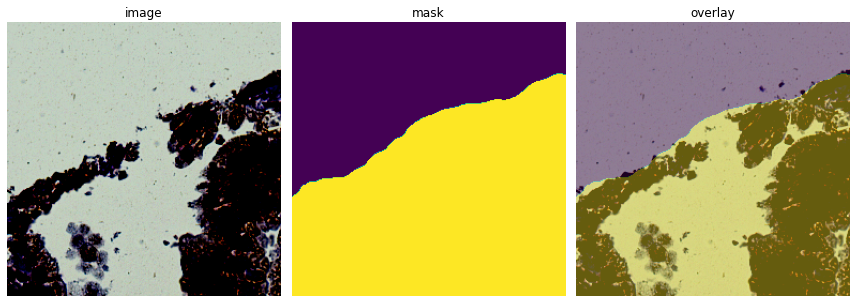

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


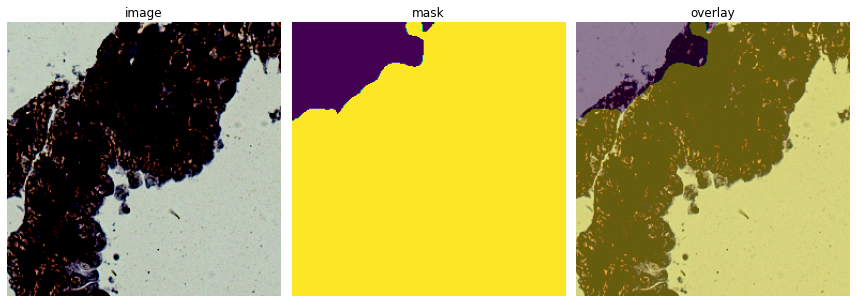

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


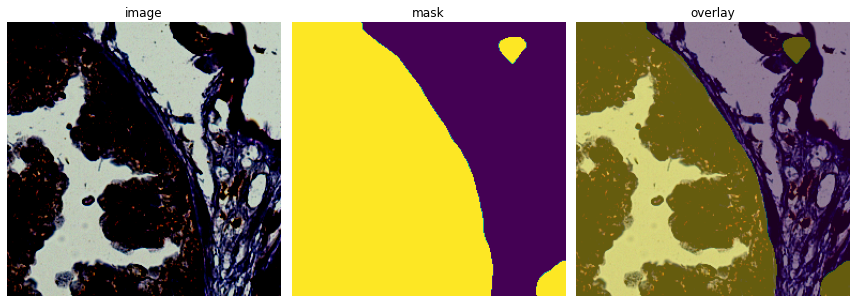

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


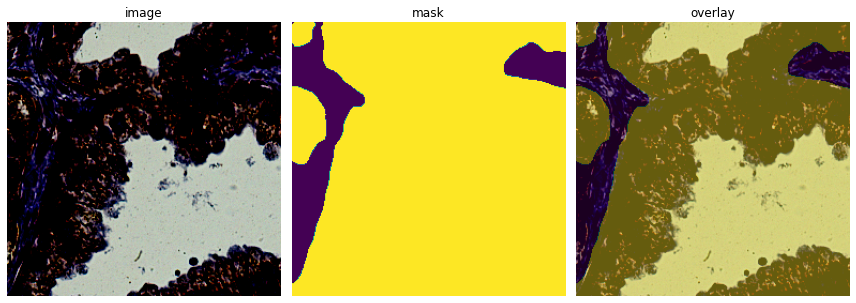

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


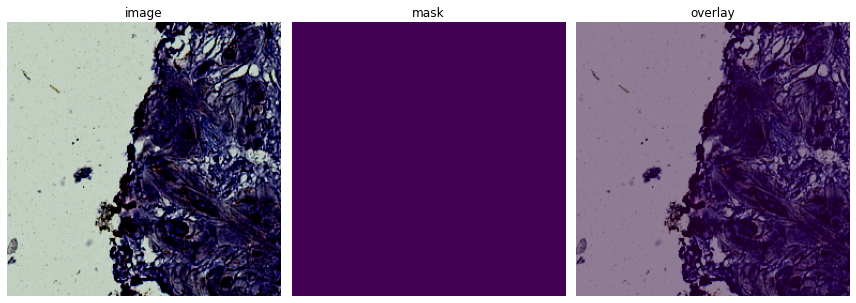

In [213]:
'''
„Éë„ÉÉ„ÉÅÂçò‰Ωç„ÅÆÁ¢∫Ë™ç
'''
if debug:
    for img, msk in zip(imgs[0][:5], msks[0][:5]):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
        plt.axis('OFF'); plt.title('image')
        # msk„ÅØÂêÑ„ÉÅ„É£„É≥„Éç„É´„ÅÆÂÄ§„Åå0„Åã1„Å™„ÅÆ„Åß„ÄÅ255„ÇíÊéõ„Åë„Çã„Åì„Å®„Åß(1,0,0)„Å™„ÇâËµ§(255,0,0)„Å´„Å™„Çã„ÄÇ
        plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
        plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

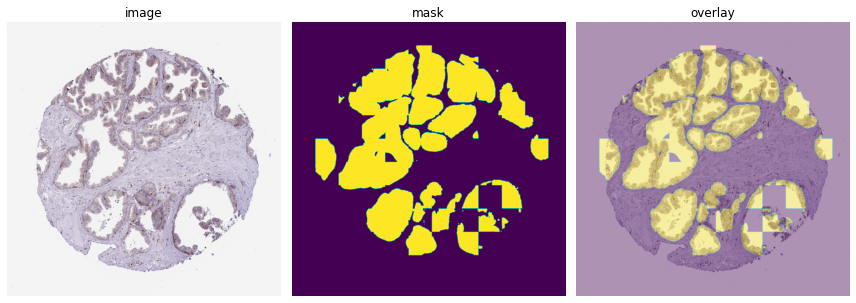

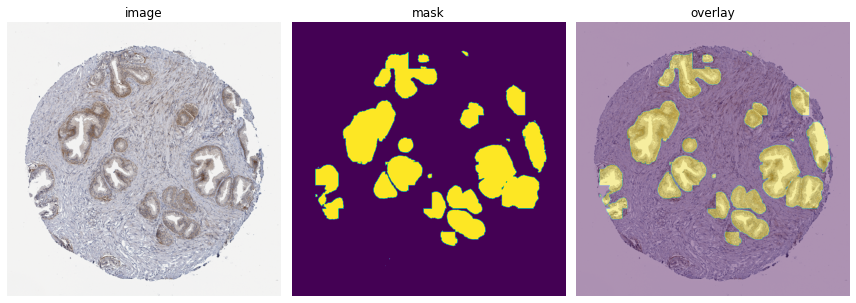

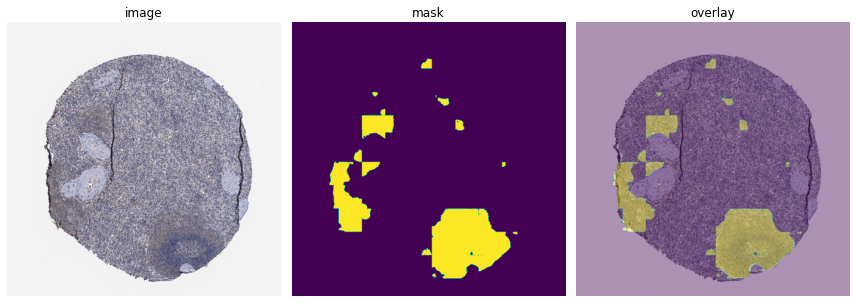

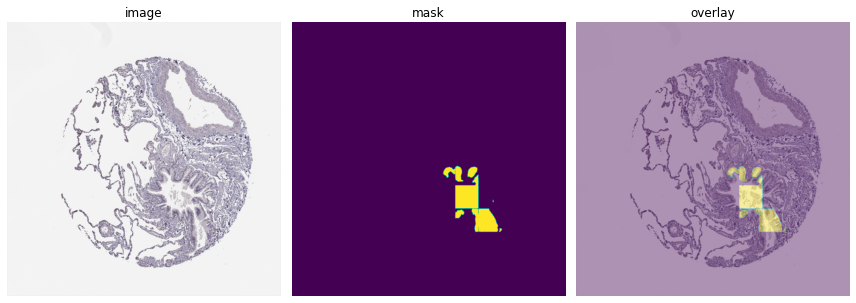

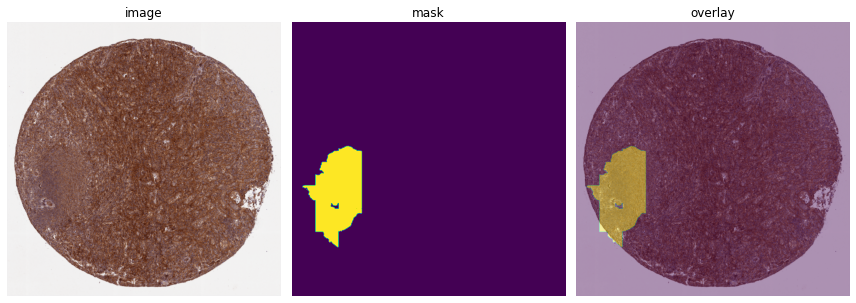

In [214]:
'''
tiffÂçò‰Ωç„ÅÆÁ¢∫Ë™ç‚ë† ‰∫àÊ∏¨mask„ÇíÁîªÂÉè„Å´Èáç„Å≠Âêà„Çè„Åõ
'''
if debug:
    for img, msk in zip(loaded_data1[:5], org_masks[:5]):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
        plt.axis('OFF'); plt.title('image')
        # msk„ÅØÂêÑ„ÉÅ„É£„É≥„Éç„É´„ÅÆÂÄ§„Åå0„Åã1„Å™„ÅÆ„Åß„ÄÅ255„ÇíÊéõ„Åë„Çã„Åì„Å®„Åß(1,0,0)„Å™„ÇâËµ§(255,0,0)„Å´„Å™„Çã„ÄÇ
        plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
        plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

In [148]:
if debug:
    del imgs, msks, loaded_data1, org_masks
else:
    del imgs, msks
gc.collect()

86920

# üìù Submission

In [149]:
# ‰∫àÊ∏¨ÁµêÊûú„ÇíDF„Å´ÂÖ•„Çå„Çã(idÂàó„ÄÅ„ÇØ„É©„ÇπÂàó„ÄÅ‰∫àÊ∏¨ÁµêÊûú)
pred_df = pd.DataFrame({
    "id":pred_ids,
    "rle":pred_strings
})

# sample_submission.csv„ÇíË™≠„ÅøËæº„Çì„Å†‰∏ä„ÅßrleÂàó„ÇíÂâäÈô§
sub_df = pd.read_csv('/home/user/Desktop/hirao/ftu_segmentation/sample_submission.csv')
del sub_df['rle']

if debug:
    # Â≠¶Áøí„Éá„Éº„Çø„ÅÆÂ†¥Âêà„ÄÅsample_submission„ÅÆË°å„ÅØ0„Å™„ÅÆ„Åß„ÄÅÂ§ñÈÉ®ÁµêÂêà„Åô„Çã
    # „Åæ„Åö„ÄÅ‰∏ÄË°åÁõÆ„ÇíÂâäÈô§
    sub_df = sub_df.drop(0)
    # Â§ñÈÉ®ÁµêÂêà
    sub_df = sub_df.merge(pred_df, on=['id'], how="outer")
else:
    # Êú¨Áï™„Éá„Éº„Çø„ÅÆÂ†¥Âêà„ÄÅsample_submission„ÅÆË°å„Åå500Ë°åÂâçÂæå„ÅÇ„Çã„ÅØ„Åö„Å™„ÅÆ„Åß„ÄÅÂÜÖÈÉ®ÁµêÂêà„Åï„Åõ„Çã„ÄÇ
    # „Éá„Éï„Ç©„É´„Éà„ÅåÂÜÖÈÉ®ÁµêÂêà„Å™„ÅÆ„Åß„ÄÅ„ÅÇ„ÇãË°å„Å†„Åë„ÅßÁµêÂêà„Åô„Çã
    sub_df = sub_df.merge(pred_df, on=['id'])

sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

id                                                rle
0  10044  757308 225 760309 224 763309 224 766309 224 76...
1  10274  757612 177 760613 176 763589 2 763611 178 7665...
2  10392  1294759 5 1294776 8 1297669 6 1297754 8 129777...
3  10488  4597851 35 4600852 34 4603808 3 4603851 34 460...
4  10610  418909 4 421905 10 424902 14 427901 16 430900 ...

# üìà Visualization2 [mask => rle‰ΩúÊàêÂæå„ÅÆÁ¢∫Ë™ç]

In [150]:
# tiffÂçò‰Ωç„ÅÆÁ¢∫Ë™ç‚ë°Áî®„ÅÆÈñ¢Êï∞„ÄÄ[„É©„É≥„É¨„É≥„Ç∞„ÇπÁ¨¶Âè∑‚û°mask]
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


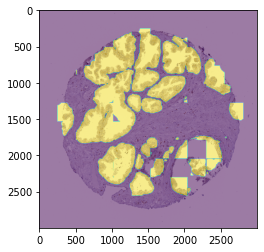

In [151]:
'''
tiffÂçò‰Ωç„ÅÆÁ¢∫Ë™ç‚ë° ‰∫àÊ∏¨rle„Åã„Çâ„Éû„Çπ„ÇØ„ÇíÂÜçÁîüÊàê„Åó„Å¶„ÄÅÂÖÉÁîªÂÉè„Å®Èáç„Å≠Âêà„Çè„Åõ
'''
if debug:
    img_t = tiff.imread('/home/user/Desktop/hirao/ftu_segmentation/train_images/10044.tiff') # Â≠¶ÁøíÁîªÂÉè„ÅÆÊØîËºÉ
#    img_t = tiff.imread('/home/user/Desktop/hirao/ftu_segmentation/test_images/10078.tiff')  # „ÉÜ„Çπ„ÉàÁîªÂÉè„ÅÆÊØîËºÉ 
    msk_rle = sub_df.iloc[0,1]
    msk_t = rle2mask(msk_rle, (img_t.shape[:2][1], img_t.shape[:2][0]))
    plt.imshow(img_t)
    plt.imshow(msk_t,alpha=0.5)
    #plt.imshow(msk_t_ud_r270,alpha=0.5)
    plt.show()


In [27]:
# ‰ΩøÁî®„Éá„Éº„Çø„ÅÆÂâäÈô§
if debug:
    del img_t, msk_rle, msk_t

In [17]:
# ‰ªñÊäïÁ®ø„ÅÆË™øÊüªÁî®„ÉÜ„Çπ„Éà
from sklearn.model_selection import KFold
kf = KFold(n_splits=4,random_state=200,shuffle=True)
ids = pd.read_csv('/home/user/Desktop/hirao/ftu_segmentation/train.csv').id.astype(str).values
ids
ids[list(kf.split(ids))[0][0]]
fnames = [fname for fname in os.listdir('/home/user/Desktop/hirao/ftu_segmentation/train_c/') if fname.split('_')[0] in ids]


In [86]:
x = np.load('/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_10_4.npy')
x = x.astype('float32')
x /= 255
print(x.shape)
#print(x.shape)
#print(x[1])
#print(x)
r = x[:,:,0]
g = x[:,:,1]
b = x[:,:,2]
r_mean = np.mean(r)
g_mean = np.mean(g)
b_mean = np.mean(b)
r_sum = np.sum(r)
print(r_sum/r.size)
print([r_mean, g_mean, b_mean])
print(r)
#np.mean(x,axis=0)


(256, 256, 3)
0.8208667039871216
[0.8208667, 0.7980982, 0.8377671]
[[0.9529412  0.9607843  0.95686275 ... 0.9607843  0.95686275 0.9607843 ]
 [0.9607843  0.9607843  0.95686275 ... 0.94509804 0.9607843  0.9607843 ]
 [0.9529412  0.9607843  0.9607843  ... 0.9607843  0.95686275 0.9607843 ]
 ...
 [0.87058824 0.83137256 0.7764706  ... 0.9607843  0.95686275 0.9607843 ]
 [0.78431374 0.72156864 0.7058824  ... 0.9607843  0.9607843  0.9529412 ]
 [0.7019608  0.6784314  0.72156864 ... 0.9607843  0.9607843  0.9607843 ]]
8


In [90]:
'''
r,g,b„Åî„Å®„Å´ÂÖ®ÁîªÂÉè„ÅÆÂπ≥ÂùáÂÄ§„ÇíÊ±Ç„ÇÅ„Çã
'''
x = os.path.join(CFG.work_dir,"train")
y = glob(x+"/*.npy")
r_sums = []
g_sums = []
b_sums = []
r_sizes = []
g_sizes = []
b_sizes = []

for i in y:
    a = np.load(i)
    a = a.astype('float32')
    a /= 255
    r = a[:,:,0]
    g = a[:,:,1]
    b = a[:,:,2]
    r_sum = np.sum(r)
    g_sum = np.sum(g)
    b_sum = np.sum(b)
    r_len = r.size
    g_len = g.size
    b_len = b.size
    r_sums.append(r_sum)
    g_sums.append(g_sum)
    b_sums.append(b_sum)
    r_sizes.append(r_len)
    g_sizes.append(g_len)
    b_sizes.append(b_len)

# r_sizes,g_sizes,b_sizes=1ÊûöÊØé„ÅÆË¶ÅÁ¥†Êï∞„ÅÆ„É™„Çπ„Éà, r_size_t=rË¶ÅÁ¥†Êï∞„ÅÆÂêàË®à
r_size_t = np.sum(r_sizes)
g_size_t = np.sum(g_sizes)
b_size_t = np.sum(b_sizes)
# r_sums,g_sums,b_sums=1ÊûöÊØé„ÅÆÂêàË®à„ÅÆ„É™„Çπ„Éà, r_sum_t=rÂÖ®ÂêàË®à
r_sum_t = np.sum(r_sums)
g_sum_t = np.sum(g_sums)
b_sum_t = np.sum(b_sums)

# r,g,b„Åù„Çå„Åû„Çå„ÅÆÂÖ®ÁîªÂÉè„Åß„ÅÆÂπ≥Âùá„Éî„ÇØ„Çª„É´ÂÄ§
r_mean = r_sum_t / r_size_t
g_mean = g_sum_t / g_size_t
b_mean = b_sum_t / b_size_t

print([r_mean,g_mean,b_mean])

[0.836421453337686, 0.8124928898583412, 0.8292974005322096]


In [91]:
'''
r,g,b„Åî„Å®„Å´ÂÖ®ÁîªÂÉè„ÅÆÊ®ôÊ∫ñÂÅèÂ∑Æ„ÇíÊ±Ç„ÇÅ„Çã
'''
r_sqs=[]
g_sqs=[]
b_sqs=[]

for i in y:
    a = np.load(i)
    a = a.astype('float32')
    a /= 255
    r = a[:,:,0]
    g = a[:,:,1]
    b = a[:,:,2]
    r_dif_sq = (r - r_mean)**2
    g_dif_sq = (g - g_mean)**2
    b_dif_sq = (b - b_mean)**2
    r_sq_sum = np.sum(r_dif_sq)
    g_sq_sum = np.sum(g_dif_sq)
    b_sq_sum = np.sum(b_dif_sq)
    # 1ÊûöÊØé„ÅÆÂÅèÂ∑Æ„ÅÆÂíå„Çír,g,b_sqs„Å´ÂÖ•„Çå„Çã
    r_sqs.append(r_sq_sum)
    g_sqs.append(g_sq_sum)
    b_sqs.append(b_sq_sum)

# ÂÖ®ÂÅèÂ∑Æ„ÅÆÂêàË®à„ÅÆÂπ≥ÊñπÊ†π„ÇíÂá∫„Åô„ÄÇ
r_sqs_sr = np.sqrt(np.sum(r_sqs))
g_sqs_sr = np.sqrt(np.sum(g_sqs))
b_sqs_sr = np.sqrt(np.sum(b_sqs))

# Ê®ôÊ∫ñÂÅèÂ∑Æ„ÇíÂá∫„Åô„ÄÇ
r_std = r_sqs_sr / r_size_t
g_std = g_sqs_sr / g_size_t
b_std = b_sqs_sr / b_size_t

print([r_std,g_std,b_std])

[2.9024501467060536e-06, 3.36166705916146e-06, 3.1559653497640376e-06]


In [89]:
xxx = np.array([10,1,3,5,31,4313,41])
(xxx - 10)**2

array([       0,       81,       49,       25,      441, 18515809,
            961])